# FINAL PIPELINE SUMMARY
# 0) Environment Set Up
# 1) Data Preprocessing
# 2) Loading the Models and the Tokenizers
# 3) Model Explanation and Testing
# 4) Method Implementation
# 5) Batch Processing of the Method
# 6) Answer Clustering and Semantic Entropy Calculation
# 7) Hallucination Detection Model - Trained to predict the label
# 8) Hallucination Detection Model - Trained to predict the semantic entropy score
# 9) Discussions


## 0) Environment Set Up
Installing/importing required libraries and setting up Hugginface and Google Drive Connections

In [ ]:
!pip install transformers datasets torch tqdm scikit-learn matplotlib accelerate

In [ ]:
import torch
import accelerate
from torch.nn import functional as F
from transformers import AutoTokenizer, AutoModelForCausalLM, AutoModelForSequenceClassification
from datasets import load_from_disk, load_dataset
import random
import math
import os
from google.colab import drive
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [ ]:
import os
token = os.environ['HF_TOKEN']

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Define the base path in your Google Drive
base_path = "/content/drive/MyDrive/hallucination-detector/"

# Create the directory if it doesn't exist
import os
os.makedirs(base_path, exist_ok=True)

## 1) Data Preprocessing
In the scope of the project, we decided to focus on questions that do not require context to be answered. Therefore, we selected TriviQA's data samples that lack context content (it was reported that these questions are designed to be answered without context).

Additionally, the test_dataset part of TriviaQA does not publicly provide labels to maintain a private leaderboard. As a result, we created our test data using the validation split of the dataset.

We generated the training and validation splits using the training split of the TriviaQA dataset.

In [ ]:
#IF THE DATA SET IS ALREADY PROCESSED, SKIP FROM HERE 1:
train_dataset = load_dataset("mandarjoshi/trivia_qa", "rc", split="train", token=token)
valid_dataset = load_dataset("mandarjoshi/trivia_qa", "rc", split="validation", token=token)
test_dataset  = load_dataset("mandarjoshi/trivia_qa", "rc", split="test", token=token)

In [ ]:
# Contexts are merged and the labels are reformatted
def format_dataset(example):
    example["context"] = " ".join(("\n".join(example["entity_pages"]["wiki_context"])).split("\n"))
    example["targets"] = example["answer"]["aliases"]
    example["norm_target"] = example["answer"]["normalized_value"]
    return example

# Applying the above function to the data set
train_ds = train_dataset.map(format_dataset, remove_columns=["search_results", "question_source", "entity_pages", "answer", "question_id"])
valid_ds = valid_dataset.map(format_dataset, remove_columns=["search_results", "question_source", "entity_pages", "answer", "question_id"])

# Selecting the samples with empty context
train_ds = train_ds.filter(lambda x: len(x['context']) == 0)
valid_ds = valid_ds.filter(lambda x: len(x['context']) == 0)

Utilizing these, let's define our training/validation/test splits

In [ ]:
# Shuffling the data sets
train_ds = train_ds.shuffle(seed=42)
valid_ds = valid_ds.shuffle(seed=42)

# Select the first 6000 rows of train_ds as the training dataset
train_split = train_ds.select(range(6000))

# Select the next 2000 rows of train_ds as the validation dataset
valid_split = train_ds.select(range(6000, 8000))

# Use the shuffled valid_ds as the test dataset
test_split = valid_ds.select(range(1800))

In [ ]:
print(f"training split size: {len(train_split)}")
print(f"validation split size: {len(valid_split)}")
print(f"test split size: {len(test_split)}")

training split size: 6000
validation split size: 2000
test split size: 1800


Here, we are saving our data sets to Drive to make the future environment setup easier

In [ ]:
# Define the base path for the nocontext_subset folder in your Google Drive
nocontext_subset_path = os.path.join(base_path, "nocontext_subset")

# Create the directory if it doesn't exist
os.makedirs(nocontext_subset_path, exist_ok=True)

# Define file paths
train_file_path = os.path.join(nocontext_subset_path, "train_processed.jsonl")
valid_file_path = os.path.join(nocontext_subset_path, "valid_processed.jsonl")
test_file_path = os.path.join(nocontext_subset_path, "test_processed.jsonl")

# Save datasets to JSONL
train_split.to_json(train_file_path)
valid_split.to_json(valid_file_path)
test_split.to_json(test_file_path)


print(f"Train dataset saved to {train_file_path}")
print(f"Validation dataset saved to {valid_file_path}")
print(f"Test dataset saved to {test_file_path}")

Loading the data from Google Drive

In [ ]:
#IF THE DATA SET IS ALREADY PROCESSED, SKIP TO HERE 1:

# Define the base path for the nocontext_subset folder in your Google Drive
nocontext_subset_path = os.path.join(base_path, "nocontext_subset")

# Define file paths
train_file_path = os.path.join(nocontext_subset_path, "train_processed.jsonl")
valid_file_path = os.path.join(nocontext_subset_path, "valid_processed.jsonl")
test_file_path = os.path.join(nocontext_subset_path, "test_processed.jsonl")

# Load the datasets from JSONL files
train_dataset = load_dataset('json', data_files=train_file_path, split='train')
valid_dataset = load_dataset('json', data_files=valid_file_path, split='train')
test_dataset = load_dataset('json', data_files=test_file_path, split='train')

In [ ]:
print(f"training split size: {len(train_dataset)}")
print(f"validation split size: {len(valid_dataset)}")
print(f"test split size: {len(test_dataset)}")

training split size: 6000
validation split size: 2000
test split size: 1800


In [ ]:
def check_dataset(dataset, name):
    print(f"\nChecking {name} dataset:")
    print(f"Number of samples: {len(dataset)}")
    print(f"Features: {dataset.features}")

    # Check for empty contexts
    empty_contexts = sum(1 for sample in dataset if len(sample['context']) == 0)
    print(f"Number of samples with empty contexts: {empty_contexts}")

    # Print a random sample
    random_sample = random.choice(dataset)
    print("\nRandom sample:")
    print(f"Question: {random_sample['question']}")
    print(f"Context (first 100 characters): {random_sample['context'][:100]}...")
    print(f"Targets: {random_sample['targets']}")
    print(f"Normalized Target: {random_sample['norm_target']}")

    # Check data types
    print("\nData types:")
    for key, value in random_sample.items():
        print(f"{key}: {type(value)}")


# Check each dataset
for dataset, name in zip([train_dataset, valid_dataset, test_dataset], ['Training', 'Validation', 'Test']):
    check_dataset(dataset, name)

# Additional overall checks
print("\nOverall checks:")
print(f"Total samples: {len(train_dataset) + len(valid_dataset) + len(test_dataset)}")
print(f"Expected total: 10000")

# Check for overlap between sets
train_questions = set(train_dataset['question'])
valid_questions = set(valid_dataset['question'])
test_questions = set(test_dataset['question'])

overlap_train_valid = train_questions.intersection(valid_questions)
overlap_train_test = train_questions.intersection(test_questions)
overlap_valid_test = valid_questions.intersection(test_questions)

print(f"\nOverlap between Train and Validation sets: {len(overlap_train_valid)}")
print(f"Overlap between Train and Test sets: {len(overlap_train_test)}")
print(f"Overlap between Validation and Test sets: {len(overlap_valid_test)}")


Checking Training dataset:
Number of samples: 6000
Features: {'question': Value(dtype='string', id=None), 'context': Value(dtype='string', id=None), 'targets': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None), 'norm_target': Value(dtype='string', id=None)}
Number of samples with empty contexts: 6000

Random sample:
Question: What Anglicized German word originally from 'harm-joy' refers to pleasure derived from misfortunes of others?
Context (first 100 characters): ...
Targets: ['Schadenfraude', 'Schaudenfreuda', 'Schaudenfreude', 'Schadenfroh', 'Morose delectation', 'Schauenfruede', 'Freudenschade', 'Delectatio morosa', 'Schadenfreud', 'Epichaerecacia', 'Epicaricacy', 'Schadenfreund', 'Chardenfreuder', 'Schaudenfraude', 'Schaeunfreude', 'Schadenhausenfreude', 'Schadenfruede', 'Schauenfreude', 'Schadenfreude experiment', 'Shadenfreude', 'Schadenfreuden', 'Epikairekakia', 'Schadenfreude']
Normalized Target: schadenfreude

Data types:
question: <class 'str'>
context: 

The checks of the dataset splits have been completed, and there are no overlaps between the splits (ensured by verifying that there are no duplicates in the dataset).

Thus, data preprocessing, splits, and duplicate checks are finalized. We can now proceed with the model and tokenizer loading phase.

## 2) Loading the models and the tokenizers

Let us directly get the models and the tokenizers from huggingface hub:

In [ ]:
print("Loading Gemma 2B model and tokenizer...")
gemma_tokenizer = AutoTokenizer.from_pretrained("google/gemma-2b-it", token=token)
gemma_model = AutoModelForCausalLM.from_pretrained(
    "google/gemma-2b-it",
    device_map="auto",
    torch_dtype=torch.bfloat16,
    output_hidden_states=True,
    token=token
)

Loading Gemma 2B model and tokenizer...


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
`config.hidden_act` is ignored, you should use `config.hidden_activation` instead.
Gemma's activation function will be set to `gelu_pytorch_tanh`. Please, use
`config.hidden_activation` if you want to override this behaviour.
See https://github.com/huggingface/transformers/pull/29402 for more details.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
print("Loading RoBERTa NLI model and tokenizer...")
nli_tokenizer = AutoTokenizer.from_pretrained("roberta-large-mnli")
nli_model = AutoModelForSequenceClassification.from_pretrained("roberta-large-mnli", device_map="auto")

Loading RoBERTa NLI model and tokenizer...


Some weights of the model checkpoint at roberta-large-mnli were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


# 3) Model Explanation and Testing

Let's explain where we will use these models:

**Gemma 2B**: This model will be the main model in this work. The objective is to develop a separate hallucination classifier to detect when the Gemma-2B model is likely to hallucinate.

**RoBERTa**: To train a hallucination detection model, we will have the Gemma-2B model generate 10 answers for each question in our training data. We will then classify these answers into groups. For example, if the question is "What is the capital of France?" and the model's outcomes are "Paris," "Monaco," and "It is Paris," the groups would be:

- Group 1: ["Paris", "It is Paris"]
- Group 2: ["Monaco"]

To group these answers semantically, we will use the RoBERTa model in the bidirectional entailment task. We will append each of the 10 answers to the question and then check the bidirectional entailment scores. If a question-answer pair has a high score (empirically determined threshold) with one of the existing answer groups, it is added to that group. Otherwise, a new answer group is created. As a result, we obtain a list of lists that provides the semantic answer groups for the given question. We then calculate the entropy based on these groups' sizes.

The intuition is that if a model is confident about a question, although it can provide answers in different syntactic forms (e.g., "Paris" or "The city of light, Paris"), they should all mean the same thing. Thus, rather than calculating entropy based on next-token distribution, we calculate it based on the semantic group distribution.

**Example**: If the model says "Paris" (in different forms) 6 times, "Berlin" 3 times, and "I don't know" once, the resulting entropy is:


-0.6log(0.6) - 0.3log(0.3) - 0.1log(0.1) = 0.9


The best case is where all answers mean "Paris," leading to an entropy of 0 (in syntactic entropy methods, this does not lead to 0 since the answer can be written with different wordings).

Our goal is to predict this semantic entropy based on the hidden vector of the last token in the question, where higher predictions for the semantic entropy signal the possibility of hallucination.


In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM, AutoModelForSequenceClassification
import torch
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Test Gemma 2B model
print("\nTesting Gemma 2B model:")
question = """
Question: What is the capital of France?
Answer: paris

Question: Which birds collect in a convocation?
Answer: eagles

Question: What is the name of the dog in the Punch and Judy shows?
Answer: toby

Question: In golf what is the old-fashioned name for a No 3 wood?
Answer: spoon

Question: When was Turkish Republic founded?
Answer: 1923

Question: Who is the first president of United States?
Answer : """


inputs = gemma_tokenizer(question, return_tensors="pt").to(device)
max_length = inputs.input_ids.size(1) + 20

with torch.no_grad():
    outputs = gemma_model.generate(**inputs, max_length=max_length, num_return_sequences=1, temperature=0)

full_response = gemma_tokenizer.decode(outputs[0], skip_special_tokens=True)
answer = full_response[len(question):].strip()
#print(f"Question: {question}")
print(f"Answer: {answer}")


Testing Gemma 2B model:


/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:515: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(


Answer: 1789 George Washington


We decided to use the Gemma-2B model to ensure smooth testing in the free Google Colab environment and prevent the possibility of GPU memory overload. Additionally, since Gemma-2B is more likely to hallucinate due to its size, and considering this work is primarily a proof-of-concept effort, we chose to proceed with the Gemma-2B model.

However, our analysis indicates that Gemma-2B performs poorly on the TriviaQA dataset, showing significantly lower accuracy compared to the technical report of Gemma models released by Google in February 2024.

To address this, we decided to use a softer evaluation metric for answer accuracy. Instead of requiring an exact match between the ground truth and the model's output, we will check for any word overlap between the prediction and the ground truth and classify the prediction as correct if there is any overlap. To prevent words like "and, or, to, at, in, etc." leading the false positives, we excluded them from the keyword match search. Details can be seend in the evaluations part.

For example, the model answers the question about the first US president with "1789 George Washington" instead of just "George Washington." We don't want to penalize the model for the extra "1789" part since the focus of this study is on hallucination detection rather than answer formatting.

In [ ]:
# Test RoBERTa NLI model
print("\nTesting RoBERTa NLI model:")
premise = "What is the capital of France? Paris"
hypothesis = "What is the capital of France? The capital of France is Paris!"

inputs = nli_tokenizer(premise, hypothesis, return_tensors="pt", truncation=True, max_length=512, padding=True).to(device)

with torch.no_grad():
    outputs = nli_model(**inputs)
    probabilities = F.softmax(outputs.logits, dim=-1)

entailment_prob = probabilities[0][2].item()
print(f"Premise: {premise}")
print(f"Hypothesis: {hypothesis}")
print(f"Entailment probability: {entailment_prob:.4f}")


Testing RoBERTa NLI model:
Premise: What is the capital of France? Paris
Hypothesis: What is the capital of France? The capital of France is Paris!
Entailment probability: 0.9404


Thanks to the high bidirectional entailment scores between question-answer pairs with the same meaning, we will cluster the model's answers into groups.

## 4) Method Implementation

The function below will be used to generate the model's best guess for the question at hand. Therefore, the generation will be done with a temperature of 0. Additionally, we will store the hidden state of the last token in the question from the final layer, as this hidden state will be used to predict the semantic entropy of the question/answer pair and allow us to estimate the hallucination probability.

In [ ]:
def generate_answer_and_get_embedding(question, model, tokenizer, device, temperature=0, additional_tokens=25):
    inputs = tokenizer(question, return_tensors="pt").to(device)
    question_length = inputs.input_ids.size(1)
    max_length = question_length + additional_tokens

    with torch.no_grad():
        generation_outputs = model.generate(
            **inputs,
            max_length=max_length,
            num_return_sequences=1,
            temperature=temperature,
            return_dict_in_generate=True,
            output_hidden_states=True
        )

    generated_sequence = generation_outputs.sequences[0]
    full_response = tokenizer.decode(generated_sequence, skip_special_tokens=True)
    answer = full_response[len(question):].strip()

    # Extract the last token's embedding from the question
    last_token_embedding = generation_outputs.hidden_states[0][-1][0][question_length-1].cpu()

    return answer, last_token_embedding

# Test the function
question = "Which team is Kobe Bryant a legend for?"
test_question = f"""
Question: What is the capital of France?
Answer: paris

Question: Which birds collect in a convocation?
Answer: eagles

Question: What is the name of the dog in the Punch and Judy shows?
Answer: toby

Question: In golf what is the old-fashioned name for a No 3 wood?
Answer: spoon

Question: When was Turkish Republic founded?
Answer: 1923

Question: {question}
Answer : """
generated_answer, last_token_embedding = generate_answer_and_get_embedding(test_question, gemma_model, gemma_tokenizer, device)

print(f"Question: {question}")
print(f"Generated answer (temp=0.1): {generated_answer}")
print(f"Last token embedding: {last_token_embedding}")

Question: Which team is Kobe Bryant a legend for?
Generated answer (temp=0.1): Los Angeles Lakers
Last token embedding: tensor([-1.4531, -1.5547, -3.0312,  ...,  0.5977, -0.0386,  0.2559],
       dtype=torch.bfloat16)


For our training data questions, in addition to running the model with temperature=0 to generate the best guess and storing the last token's hidden state, we will also run the model with temperature=0.8 to generate 10 answers. We will then cluster these 10 answers into semantic groups and calculate the entropy of the answers. The goal is to fit a logistic regression model that will predict the semantic entropy of the answers based solely on the question's last token's embedding.

This approach allows us, during test time, to predict whether an output is a hallucination or not by only generating the best guess (without generating 10 answers). Indeed, even without answer generation, we can use this model to understand if the model would hallucinate if we let it generate an answer because whole prediction depends on the hidden state of the last question token.

In [ ]:
def generate_alternative_answers(question, model, tokenizer, device, n=10, temperature=0.8, top_p=0.9, additional_tokens=25):
    inputs = tokenizer(question, return_tensors="pt").to(device)
    question_length = inputs.input_ids.size(1)
    max_length = question_length + additional_tokens

    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_length=max_length,
            num_return_sequences=n,
            temperature=temperature,
            top_p=top_p,
            do_sample=True
        )

    alternative_answers = []
    for output in outputs:
        full_response = tokenizer.decode(output, skip_special_tokens=True)
        answer = full_response[len(question):].strip()
        alternative_answers.append(answer)

    return alternative_answers

The code below is used to cluster the answers into semantic groups

In [ ]:
import torch.nn.functional as F

def check_entailment(premise, hypothesis, nli_model, nli_tokenizer, device):
    inputs = nli_tokenizer(premise, hypothesis, return_tensors="pt", truncation=True, max_length=512, padding=True).to(device)
    with torch.no_grad():
        outputs = nli_model(**inputs)
        probabilities = F.softmax(outputs.logits, dim=-1)
        entailment_prob = probabilities[0][2].item()  # Probability of entailment
    return entailment_prob

def bidirectional_entailment(text1, text2, nli_model, nli_tokenizer, device):
    score1 = check_entailment(text1, text2, nli_model, nli_tokenizer, device)
    score2 = check_entailment(text2, text1, nli_model, nli_tokenizer, device)
    return max(score1, score2)

def cluster_answers(question, answers, nli_model, nli_tokenizer, device, threshold=0.1):
    grouped_answers = []
    for answer in answers:
        qa_pair = f"{question} {answer}"
        matched = False
        for group in grouped_answers:
            group_head = f"{question} {group[0]}"
            if bidirectional_entailment(qa_pair, group_head, nli_model, nli_tokenizer, device) >= threshold:
                group.append(answer)
                matched = True
                break
        if not matched:
            grouped_answers.append([answer])
    return grouped_answers

def group_answers(question, answers, nli_model, nli_tokenizer, device, threshold=0.4):
    return cluster_answers(question, answers, nli_model, nli_tokenizer, device, threshold)

And the code below is used to calculate the semantic entropy of the generated answers

In [ ]:
import math

def calculate_entropy(groups):
    total_answers = sum(len(group) for group in groups)
    probabilities = [len(group) / total_answers for group in groups]

    entropy = 0
    for p in probabilities:
        if p > 0:  # Avoid log(0)
            entropy -= p * math.log2(p)  # Using log base 2 for entropy calculation

    return entropy

In the following, we see an example of Gemma-2B model generating 10 answers for a given question. After that, these answers are clustered into semantic groups and the corresponding semantic entropy is calculated

In [ ]:
question = "Who is the author of harry potter novels?"
test_question = f"""
Question: What is the capital of France?
Answer: paris

Question: What is the famous dance move of Michael Jackson?
Answer: moonwalk

Question: Which birds collect in a convocation?
Answer: eagles

Question: What is the name of the dog in the Punch and Judy shows?
Answer: toby

Question: Who is the first president of United States?
Answer: george washington

Question: {question}
Answer : """
alt_answers = generate_alternative_answers(test_question, gemma_model, gemma_tokenizer, device)
print(alt_answers)

['7. J. K. Rowling', 'J.K. Rowling', 'J.K. Rowling', '7. J. K. Rowling', 'J.K. Rowling', 'J.K. Rowling', 'J.K. Rowling', '7. J. K. Rowling', '7. j. k. Rowling', 'J.K. Rowling']


In [ ]:
# Group the answers
grouped_answers = group_answers(question, alt_answers, nli_model, nli_tokenizer, device)
print("\nGrouped Answers:")
for i, group in enumerate(grouped_answers, 1):
    print(f"Group {i}: {group}")

# Calculate entropy
entropy = calculate_entropy(grouped_answers)
print(f"\nEntropy of answer distribution: {entropy}")


Grouped Answers:
Group 1: ['7. J. K. Rowling', 'J.K. Rowling', 'J.K. Rowling', '7. J. K. Rowling', 'J.K. Rowling', 'J.K. Rowling', 'J.K. Rowling', '7. J. K. Rowling', '7. j. k. Rowling', 'J.K. Rowling']

Entropy of answer distribution: 0.0


Now, let's create the batch processing code for these functions

## 5) Batch Processing of the Method

Adding few shot examples to be used in training and test time

In [ ]:
FEW_SHOT_EXAMPLES = """
Question: What is the capital of France?
Answer: paris
Question: What is the famous dance move of Michael Jackson?
Answer: moonwalk
Question: Which birds collect in a convocation?
Answer: eagles
Question: What is the name of the dog in the Punch and Judy shows?
Answer: toby
Question: Who is the first president of United States?
Answer: george washington
"""

In [ ]:
def format_question_with_examples(question):
    return f"{FEW_SHOT_EXAMPLES} Question: {question}\nAnswer:"

In [ ]:
def save_item(item, file_path):
    with open(file_path, 'a') as f:
        json.dump(item, f)
        f.write('\n')

def load_processed_items(file_path):
    processed_items = []
    if os.path.exists(file_path):
        with open(file_path, 'r') as f:
            for line in f:
                processed_items.append(json.loads(line))
    return processed_items

In [ ]:
# SKIP THIS IF THE ANSWERS AND EMBEDDINGS ARE ALREADY PRODUCED
import torch, json
from tqdm import tqdm

base_path = "/content/drive/MyDrive/hallucination-detector/"
train_save_path = os.path.join(base_path, "processed_data/train_processed.jsonl")
valid_save_path = os.path.join(base_path, "processed_data/valid_processed.jsonl")
test_save_path = os.path.join(base_path, "processed_data/test_processed.jsonl")

os.makedirs(os.path.dirname(train_save_path), exist_ok=True)

def monitor_memory():
    print(f"Allocated: {torch.cuda.memory_allocated() / 1e9:.2f} GB")
    print(f"Reserved: {torch.cuda.memory_reserved() / 1e9:.2f} GB")

def generate_answers_and_get_embeddings_batch(questions, model, tokenizer, device, temperature=0, additional_tokens=25):
    formatted_questions = [format_question_with_examples(q) for q in questions]

    inputs = tokenizer(formatted_questions, return_tensors="pt", padding=True, truncation=True).to(device)
    question_lengths = inputs.attention_mask.sum(dim=1)
    max_length = inputs.input_ids.size(1) + additional_tokens

    with torch.no_grad():
        generation_outputs = model.generate(
            **inputs,
            max_length=max_length,
            num_return_sequences=1,
            temperature=temperature,
            return_dict_in_generate=True,
            output_hidden_states=True
        )

    generated_sequences = generation_outputs.sequences
    full_responses = tokenizer.batch_decode(generated_sequences, skip_special_tokens=True)
    answers = [full_response[len(formatted_q):].strip() for full_response, formatted_q in zip(full_responses, formatted_questions)]

    # Extract the last token's embedding for each question
    last_token_embeddings = [generation_outputs.hidden_states[0][-1][i][question_length-1].cpu()
                             for i, question_length in enumerate(question_lengths)]

    # Clear intermediate variables
    del inputs, generation_outputs, generated_sequences
    torch.cuda.empty_cache()

    return answers, last_token_embeddings

def generate_alternative_answers_batch(questions, model, tokenizer, device, n=10, temperature=0.8, top_p=0.9, additional_tokens=25):
    formatted_questions = [format_question_with_examples(q) for q in questions]

    inputs = tokenizer(formatted_questions, return_tensors="pt", padding=True, truncation=True).to(device)
    max_length = inputs.input_ids.size(1) + additional_tokens

    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_length=max_length,
            num_return_sequences=n,
            temperature=temperature,
            top_p=top_p,
            do_sample=True
        )

    # Reshape outputs to group alternative answers for each question
    outputs = outputs.view(len(questions), n, -1)

    all_alternative_answers = []
    for i, formatted_q in enumerate(formatted_questions):
        alternative_answers = []
        for output in outputs[i]:
            full_response = tokenizer.decode(output, skip_special_tokens=True)
            answer = full_response[len(formatted_q):].strip()
            alternative_answers.append(answer)
        all_alternative_answers.append(alternative_answers)

    # Clear intermediate variables
    del inputs, outputs
    torch.cuda.empty_cache()

    return all_alternative_answers

def process_dataset_batch(dataset, gemma_model, gemma_tokenizer, device, save_path, is_test=False, save_interval=100, batch_size=8):
    processed_data = load_processed_items(save_path)
    start_index = len(processed_data)

    for i in tqdm(range(start_index, len(dataset), batch_size), initial=start_index//batch_size, total=len(dataset)//batch_size):
        batch = dataset[i:i+batch_size]

        if isinstance(batch, str):
            questions = [batch]
        elif isinstance(batch, dict):
            questions = batch.get('question', [])
            if isinstance(questions, str):
                questions = [questions]
        elif isinstance(batch, list):
            questions = [item['question'] if isinstance(item, dict) else item for item in batch]
        else:
            raise ValueError(f"Unexpected batch type: {type(batch)}")

        monitor_memory()  # Check memory before generation

        # Generate best guess with temperature 0
        answers_0_7, last_token_embeddings = generate_answers_and_get_embeddings_batch(
            questions, gemma_model, gemma_tokenizer, device, temperature=0, additional_tokens=25
        )

        if not is_test:
            # Generate 10 alternative answers for each question
            all_alt_answers = generate_alternative_answers_batch(
                questions, gemma_model, gemma_tokenizer, device, n=10, temperature=0.8, additional_tokens=25
            )

        # Process and save each item in the batch
        for j, question in enumerate(questions):
            norm_target = dataset[i+j].get('norm_target', '')  # Get the normalized target
            targets = dataset[i+j].get('targets', [])  # Get the list of alternative targets

            if is_test:
                processed_item = {
                    'question': question,
                    'answer_0_7': answers_0_7[j],
                    'last_token_embedding': last_token_embeddings[j].tolist(),
                    'norm_target': norm_target,
                    'targets': targets
                }
            else:
                processed_item = {
                    'question': question,
                    'answer_0_7': answers_0_7[j],
                    'last_token_embedding': last_token_embeddings[j].tolist(),
                    'alt_answers': all_alt_answers[j],
                    'norm_target': norm_target,
                    'targets': targets
                }

            save_item(processed_item, save_path)
            processed_data.append(processed_item)

        if (i + batch_size) % save_interval == 0:
            print(f"Processed and saved {i + batch_size} items")

        # Clear GPU memory after each batch
        torch.cuda.empty_cache()
        #monitor_memory()  # Check memory after clearing

    return processed_data

# Process datasets with batch processing
batch_size = 8
#print("Debug: First item in dataset:")
#print(train_dataset[0])

train_processed = process_dataset_batch(train_dataset, gemma_model, gemma_tokenizer, device, train_save_path, batch_size=batch_size)
valid_processed = process_dataset_batch(valid_dataset, gemma_model, gemma_tokenizer, device, valid_save_path, batch_size=batch_size)
test_processed = process_dataset_batch(test_dataset, gemma_model, gemma_tokenizer, device, test_save_path, is_test=True, batch_size=batch_size)

Let's read the saved files

In [ ]:
import json

def read_jsonl(file_path):
    data = []
    with open(file_path, 'r', encoding='utf-8') as file:
        for line in file:
            data.append(json.loads(line.strip()))
    return data

In [ ]:
# Define the file paths
base_path = "/content/drive/MyDrive/hallucination-detector/"
train_file_path = os.path.join(base_path, "processed_data/train_processed.jsonl")
valid_file_path = os.path.join(base_path, "processed_data/valid_processed.jsonl")
test_file_path = os.path.join(base_path, "processed_data/test_processed.jsonl")

# Read the files
train_data_read = read_jsonl(train_file_path)
valid_data_read = read_jsonl(valid_file_path)
test_data_read = read_jsonl(test_file_path)

# Print some information about the loaded data
print(f"Loaded {len(train_data_read)} training samples")
print(f"Loaded {len(valid_data_read)} validation samples")
print(f"Loaded {len(test_data_read)} test samples")

Loaded 6000 training samples
Loaded 2000 validation samples
Loaded 1800 test samples


## 6) Answer Clustering and Semantic Entropy Calculation

So far, we calculated the best guess for each question (temperature=0 guess) as well as 10 alternative answers (generated with top_p=0.9 and temperature=0.8)

Now, we will cluster the answers into semantic groups and calculate the corresponding semantic entropy

In [ ]:
#IF DATA ALREADY SAVED, YOU CAN SKIP FROM HERE 2:
import torch
import torch.nn.functional as F
import json
from tqdm import tqdm
import math
import os

# Assuming you have already defined these functions:
# check_entailment, bidirectional_entailment, cluster_answers, group_answers, calculate_entropy

def process_item(item, nli_model, nli_tokenizer, device):
    question = item['question']
    alt_answers = item['alt_answers']

    # Generate clustered groups
    clustered_groups = group_answers(question, alt_answers, nli_model, nli_tokenizer, device)
    item['clustered_groups'] = clustered_groups

    # Calculate semantic entropy
    semantic_entropy = calculate_entropy(clustered_groups)
    item['semantic_entropy'] = semantic_entropy

    return item

def process_and_save_data(data, nli_model, nli_tokenizer, device, output_path):
    with open(output_path, 'w', encoding='utf-8') as f:
        for item in tqdm(data, desc="Processing items"):
            processed_item = process_item(item, nli_model, nli_tokenizer, device)
            json.dump(processed_item, f)
            f.write('\n')

# Assuming nli_model and nli_tokenizer are already loaded and available

# Define input and output paths
base_path = "/content/drive/MyDrive/hallucination-detector/"
train_input_path = os.path.join(base_path, "processed_data/train_processed.jsonl")
valid_input_path = os.path.join(base_path, "processed_data/valid_processed.jsonl")
train_output_path = os.path.join(base_path, "processed_data/train_processed_clustered.jsonl")
valid_output_path = os.path.join(base_path, "processed_data/valid_processed_clustered.jsonl")

# Read the input files
def read_jsonl(file_path):
    data = []
    with open(file_path, 'r', encoding='utf-8') as file:
        for line in file:
            data.append(json.loads(line.strip()))
    return data

train_data = read_jsonl(train_input_path)
valid_data = read_jsonl(valid_input_path)

# Process and save train data
print("Processing train data...")
process_and_save_data(train_data, nli_model, nli_tokenizer, device, train_output_path)

# Process and save validation data
print("Processing validation data...")
process_and_save_data(valid_data, nli_model, nli_tokenizer, device, valid_output_path)

print("Processing complete. New files saved with 'clustered' extension.")

Processing train data...


Processing items: 100%|██████████| 6000/6000 [1:08:12<00:00,  1.47it/s]


Processing validation data...


Processing items: 100%|██████████| 2000/2000 [22:22<00:00,  1.49it/s]

Processing complete. New files saved with 'clustered' extension.


In [ ]:
import os
import json
import re
from tqdm import tqdm

# Define a set of stop words to remove so that they won't lead to false positives in prediction <-> label comparison
STOP_WORDS = set(['and', 'in', 'on', 'or', 'at', 'the', 'a', 'an', 'of', 'to', 'for', 'with', 'by', 'from', 'up', 'about', 'into', 'over', 'after'])

def preprocess_target(text):
    # Convert to lowercase
    text = text.lower()
    # Remove punctuation and apostrophe s's
    text = re.sub(r"[^\w\s]|'s", "", text)
    # Split into words, remove trailing 's', filter out stop words, and keep words of 4 or more characters
    words = [word[:-1] if word.endswith('s') else word for word in text.split()
             if word not in STOP_WORDS and len(word) >= 4]
    return words

def compare_answer_target(answer, target):
    target_words = preprocess_target(target)
    answer = answer.lower()  # Convert answer to lowercase for case-insensitive comparison

    # Check if any target word is in the answer
    return any(word in answer for word in target_words)

def process_file(file_path):
    processed_data = []
    with open(file_path, 'r', encoding='utf-8') as file:
        for line in tqdm(file, desc=f"Processing {os.path.basename(file_path)}"):
            item = json.loads(line)
            answer = item['answer_0_7']
            target = item['norm_target']

            item['Label'] = compare_answer_target(answer, target)
            processed_data.append(item)

    return processed_data

# Define file paths
base_path = "/content/drive/MyDrive/hallucination-detector/"
train_path = os.path.join(base_path, "processed_data/train_processed_clustered.jsonl")
valid_path = os.path.join(base_path, "processed_data/valid_processed_clustered.jsonl")
test_path = os.path.join(base_path, "processed_data/test_processed.jsonl")

# Process each file
train_data = process_file(train_path)
valid_data = process_file(valid_path)
test_data = process_file(test_path)

# Save processed data
def save_processed_data(data, file_path):
    with open(file_path, 'w', encoding='utf-8') as file:
        for item in data:
            json.dump(item, file)
            file.write('\n')

save_processed_data(train_data, os.path.join(base_path, "processed_data/train_processed_labeled.jsonl"))
save_processed_data(valid_data, os.path.join(base_path, "processed_data/valid_processed_labeled.jsonl"))
save_processed_data(test_data, os.path.join(base_path, "processed_data/test_processed_labeled.jsonl"))

print("Processing complete. New files saved with 'labeled' extension.")

Processing train_processed_clustered.jsonl: 6000it [00:02, 2274.01it/s]
Processing valid_processed_clustered.jsonl: 2000it [00:00, 2209.67it/s]
Processing test_processed.jsonl: 1800it [00:00, 2298.85it/s]


Processing complete. New files saved with 'labeled' extension.


In [ ]:
#IF DATA ALREADY SAVED, YOU CAN SKIP TO HERE 2:

import json
import os
from tqdm import tqdm

def load_jsonl(file_path):
    data = []
    with open(file_path, 'r', encoding='utf-8') as file:
        for line in tqdm(file, desc=f"Loading {os.path.basename(file_path)}"):
            data.append(json.loads(line.strip()))
    return data

# Define the base path and file paths
base_path = "/content/drive/MyDrive/hallucination-detector/"
train_file_path = os.path.join(base_path, "processed_data/train_processed_labeled.jsonl")
valid_file_path = os.path.join(base_path, "processed_data/valid_processed_labeled.jsonl")
test_file_path = os.path.join(base_path, "processed_data/test_processed_labeled.jsonl")

# Load the data
train_data_labeled = load_jsonl(train_file_path)
valid_data_labeled = load_jsonl(valid_file_path)
test_data_labeled = load_jsonl(test_file_path)

# Print some information to verify the loading
print(f"Loaded {len(train_data_labeled)} training samples")
print(f"Loaded {len(valid_data_labeled)} validation samples")
print(f"Loaded {len(test_data_labeled)} test samples")

# Optionally, you can print the keys of the first item in each dataset to verify the structure
print("\nKeys in a training sample:")
print(list(train_data_labeled[0].keys()))
print("\nKeys in a validation sample:")
print(list(valid_data_labeled[0].keys()))
print("\nKeys in a test sample:")
print(list(test_data_labeled[0].keys()))

Loading train_processed_labeled.jsonl: 6000it [00:03, 1948.56it/s]
Loading valid_processed_labeled.jsonl: 2000it [00:01, 1311.37it/s]
Loading test_processed_labeled.jsonl: 1800it [00:01, 1438.97it/s]

Loaded 6000 training samples
Loaded 2000 validation samples
Loaded 1800 test samples

Keys in a training sample:
['question', 'answer_0_7', 'last_token_embedding', 'alt_answers', 'norm_target', 'targets', 'clustered_groups', 'semantic_entropy', 'Label']

Keys in a validation sample:
['question', 'answer_0_7', 'last_token_embedding', 'alt_answers', 'norm_target', 'targets', 'clustered_groups', 'semantic_entropy', 'Label']

Keys in a test sample:
['question', 'answer_0_7', 'last_token_embedding', 'norm_target', 'targets', 'Label']


In [ ]:
# Print some statistics
for dataset, name in zip([train_data_labeled, valid_data_labeled, test_data_labeled], ['Train', 'Validation', 'Test']):
    total = len(dataset)
    true_count = sum(1 for item in dataset if item['Label'])
    false_count = total - true_count
    print(f"{name} dataset:")
    print(f"  Total entries: {total}")
    print(f"  True labels: {true_count} ({true_count/total:.2%})")
    print(f"  False labels: {false_count} ({false_count/total:.2%})")
    print()

Train dataset:
  Total entries: 6000
  True labels: 1220 (20.33%)
  False labels: 4780 (79.67%)

Validation dataset:
  Total entries: 2000
  True labels: 392 (19.60%)
  False labels: 1608 (80.40%)

Test dataset:
  Total entries: 1800
  True labels: 368 (20.44%)
  False labels: 1432 (79.56%)



In [ ]:
def calculate_average_entropy(data, label):
    entropies = [item['semantic_entropy'] for item in data if item['Label'] == label]
    return sum(entropies) / len(entropies) if entropies else 0

# Calculate and print average entropies for train and validation sets
for dataset, name in zip([train_data_labeled, valid_data_labeled], ['Train', 'Validation']):
    true_avg_entropy = calculate_average_entropy(dataset, True)
    false_avg_entropy = calculate_average_entropy(dataset, False)

    print(f"{name} dataset:")
    print(f"  Average entropy for True labels: {true_avg_entropy:.4f}")
    print(f"  Average entropy for False labels: {false_avg_entropy:.4f}")
    print(f"  Difference (True - False): {true_avg_entropy - false_avg_entropy:.4f}")
    print()

# Calculate overall statistics for train and validation combined
all_data = train_data_labeled + valid_data_labeled
overall_true_avg_entropy = calculate_average_entropy(all_data, True)
overall_false_avg_entropy = calculate_average_entropy(all_data, False)

print("Overall statistics (Train + Validation):")
print(f"  Average entropy for True labels: {overall_true_avg_entropy:.4f}")
print(f"  Average entropy for False labels: {overall_false_avg_entropy:.4f}")
print(f"  Difference (True - False): {overall_true_avg_entropy - overall_false_avg_entropy:.4f}")

Train dataset:
  Average entropy for True labels: 0.7165
  Average entropy for False labels: 1.5288
  Difference (True - False): -0.8123

Validation dataset:
  Average entropy for True labels: 0.7605
  Average entropy for False labels: 1.4707
  Difference (True - False): -0.7102

Overall statistics (Train + Validation):
  Average entropy for True labels: 0.7272
  Average entropy for False labels: 1.5142
  Difference (True - False): -0.7870


We have great results! Our hypothesis seems to be correct about the negative correlation between semantic entropy and accuracy in model outputs.

Now, let's train a logistic regression model that takes the question's last token's final layer hidden state as input and predicts the entropy value as output. If we can derive a good logistic regression model, we can use this to predict whether a given question will lead the Gemma-2B model to hallucinate or not!

## 7) Hallucination Detection Model - Trained to predict the label


In the first version of our logistic regressor, we will use the "best guess's accuracy" as our label, which serves as a supervised task. In the next section, we will replace this label with the semantic entropy as the target (y) of the logistic regression, where the predicted semantic entropy will function as a proxy for the accuracy of the model's generations.

Now, let's focus on the scenario where we are using the best guess accuracy as the label for our training:

In [ ]:
# IF DATA FRAMES ARE ALREADY SAVED, SKIP FROM HERE 3:

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import os

# Define the base path
base_path = "/content/drive/MyDrive/hallucination-detector/"

# 1. Data Preparation
def prepare_data(data):
    df = pd.DataFrame(data)
    columns = ['last_token_embedding', 'Label']
    if 'semantic_entropy' in df.columns:
        columns.append('semantic_entropy')
    return df[columns]

# Prepare DataFrames
train_df_labeled = prepare_data(train_data_labeled)
valid_df_labeled = prepare_data(valid_data_labeled)
test_df_labeled = prepare_data(test_data_labeled)

# Save DataFrames as CSV
train_csv_path = os.path.join(base_path, "processed_data/train_df_labeled.csv")
valid_csv_path = os.path.join(base_path, "processed_data/valid_df_labeled.csv")
test_csv_path = os.path.join(base_path, "processed_data/test_df_labeled.csv")

train_df_labeled.to_csv(train_csv_path, index=False)
valid_df_labeled.to_csv(valid_csv_path, index=False)
test_df_labeled.to_csv(test_csv_path, index=False)

print("DataFrames saved as CSV files.")

DataFrames saved as CSV files.


In [ ]:
# IF DATA FRAMES ARE ALREADY SAVED, SKIP TO HERE 3:

import pandas as pd
import numpy as np
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

# Save DataFrames as CSV
train_csv_path = os.path.join(base_path, "processed_data/train_df_labeled.csv")
valid_csv_path = os.path.join(base_path, "processed_data/valid_df_labeled.csv")
test_csv_path = os.path.join(base_path, "processed_data/test_df_labeled.csv")

# Read CSV files back into DataFrames
train_df_labeled = pd.read_csv(train_csv_path)
valid_df_labeled = pd.read_csv(valid_csv_path)
test_df_labeled = pd.read_csv(test_csv_path)
print("DataFrames loaded from CSV files.")

# Convert string representation of list back to numpy array
train_df_labeled['embedding'] = train_df_labeled['last_token_embedding'].apply(lambda x: np.array(eval(x)))
valid_df_labeled['embedding'] = valid_df_labeled['last_token_embedding'].apply(lambda x: np.array(eval(x)))
test_df_labeled['embedding'] = test_df_labeled['last_token_embedding'].apply(lambda x: np.array(eval(x)))

# Combine train and valid for threshold selection
combined_df = pd.concat([train_df_labeled, valid_df_labeled])

DataFrames loaded from CSV files.


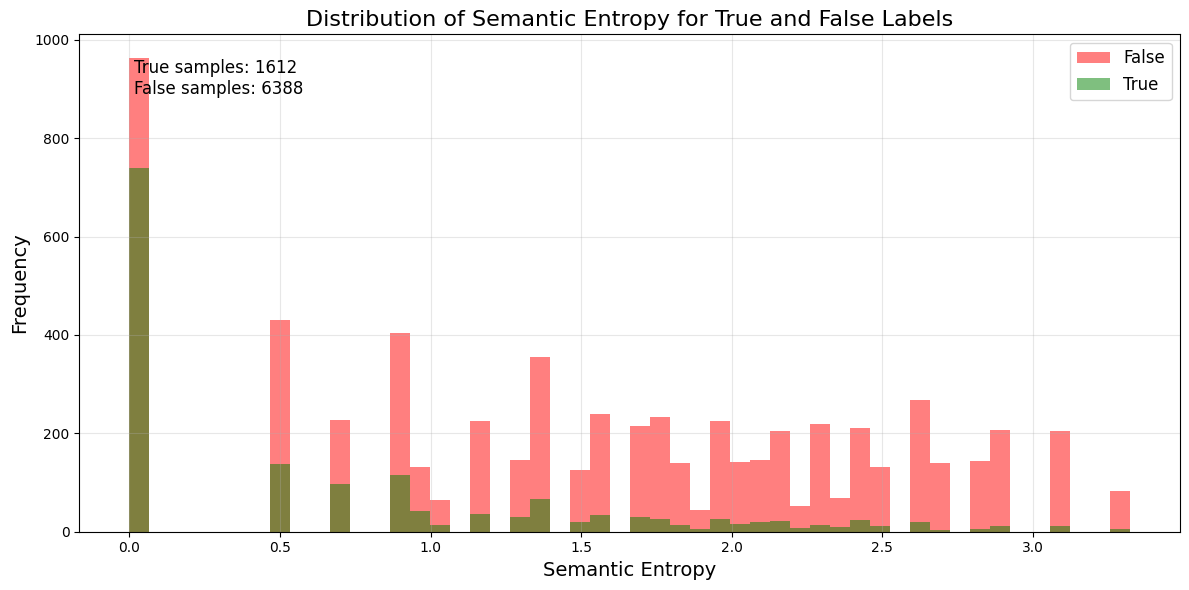

True labels - Mean: 0.7272, Std: 0.8510
False labels - Mean: 1.5142, Std: 0.9598


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'combined_df' is your DataFrame containing both training and validation data

# Separate the data for True and False labels
true_entropy = combined_df[combined_df['Label'] == True]['semantic_entropy']
false_entropy = combined_df[combined_df['Label'] == False]['semantic_entropy']

# Define the number of bins and range
bins = 50
range_min = min(combined_df['semantic_entropy'].min(), 0)  # In case there are negative values
range_max = combined_df['semantic_entropy'].max()

# Create the plot
plt.figure(figsize=(12, 6))

# Plot histogram for False labels (red)
plt.hist(false_entropy, bins=bins, range=(range_min, range_max), color='red', alpha=0.5, label='False')

# Plot histogram for True labels (green)
plt.hist(true_entropy, bins=bins, range=(range_min, range_max), color='green', alpha=0.5, label='True')

# Customize the plot
plt.title('Distribution of Semantic Entropy for True and False Labels', fontsize=16)
plt.xlabel('Semantic Entropy', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)

# Add text with data statistics
plt.text(0.05, 0.95, f"True samples: {len(true_entropy)}\nFalse samples: {len(false_entropy)}",
         transform=plt.gca().transAxes, verticalalignment='top', fontsize=12)

plt.tight_layout()
plt.show()

# Print some statistics
print(f"True labels - Mean: {true_entropy.mean():.4f}, Std: {true_entropy.std():.4f}")
print(f"False labels - Mean: {false_entropy.mean():.4f}, Std: {false_entropy.std():.4f}")

As can be seen from the graph, True samples tend to result from lower semantic entropy, while false samples tend to result from higher semantic entropy.

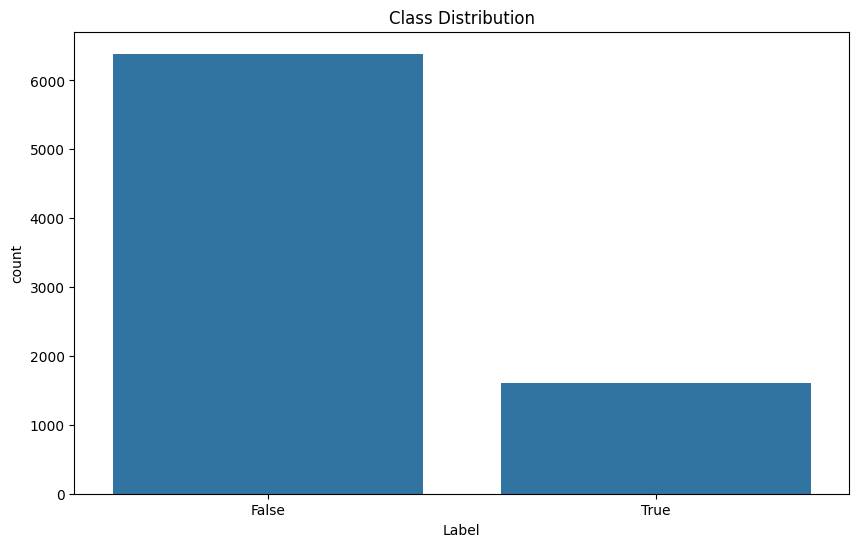

Class distribution:
Label
False    0.7985
True     0.2015
Name: proportion, dtype: float64


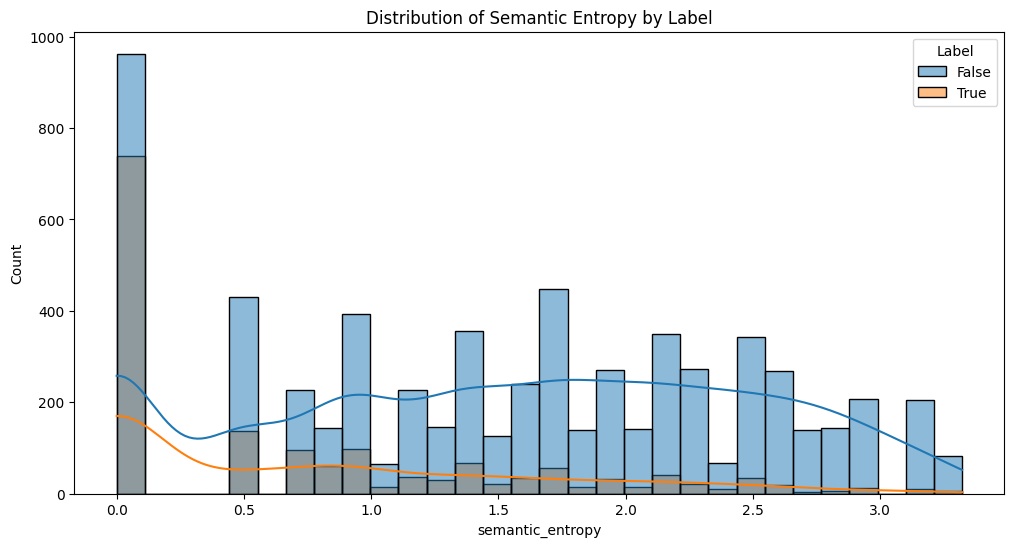


Entropy statistics:
        count      mean       std  min       25%       50%       75%       max
Label                                                                         
False  6388.0  1.514209  0.959819  0.0  0.721928  1.570951  2.321928  3.321928
True   1612.0  0.727224  0.850998  0.0  0.000000  0.468996  1.295462  3.321928


In [ ]:
# 1. Data Analysis and Visualization

# Class distribution
plt.figure(figsize=(10, 6))
sns.countplot(x='Label', data=combined_df)
plt.title('Class Distribution')
plt.show()

print("Class distribution:")
print(combined_df['Label'].value_counts(normalize=True))

# Entropy distribution (if available)
if 'semantic_entropy' in combined_df.columns:
    plt.figure(figsize=(12, 6))
    sns.histplot(data=combined_df, x='semantic_entropy', hue='Label', kde=True, bins=30)
    plt.title('Distribution of Semantic Entropy by Label')
    plt.show()

    print("\nEntropy statistics:")
    print(combined_df.groupby('Label')['semantic_entropy'].describe())

In [ ]:
# 2. Model Training and Evaluation

# Prepare the data
X_train = np.stack(combined_df['embedding'].values)
y_train = combined_df['Label']

X_test = np.stack(test_df_labeled['embedding'].values)
y_test = test_df_labeled['Label']

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train the model
model = LogisticRegression(max_iter=5000, solver='lbfgs', C=0.001)
model.fit(X_train_scaled, y_train)

# Cross-validation
cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5)
print("\nCross-validation scores:", cv_scores)
print(f"Mean CV score: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

# Predictions on test set
y_pred = model.predict(X_test_scaled)
y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]


Cross-validation scores: [0.795    0.8      0.793125 0.79375  0.79375 ]
Mean CV score: 0.7951 (+/- 0.0050)



Classification Report:
              precision    recall  f1-score   support

       False       0.80      1.00      0.89      1432
        True       0.60      0.02      0.05       368

    accuracy                           0.80      1800
   macro avg       0.70      0.51      0.47      1800
weighted avg       0.76      0.80      0.71      1800



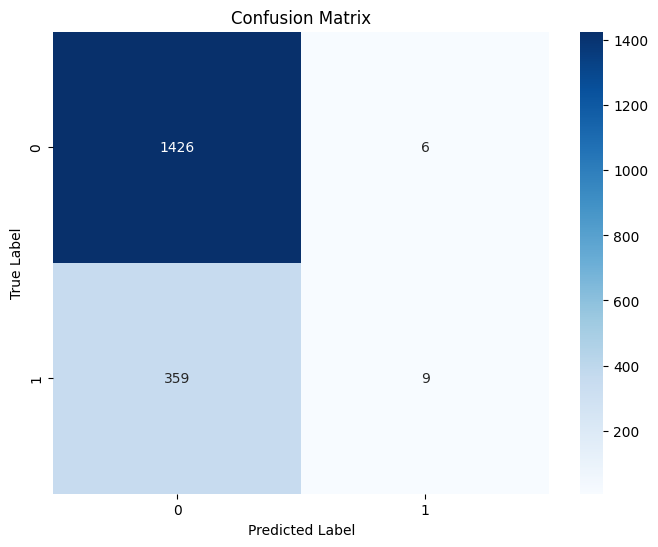

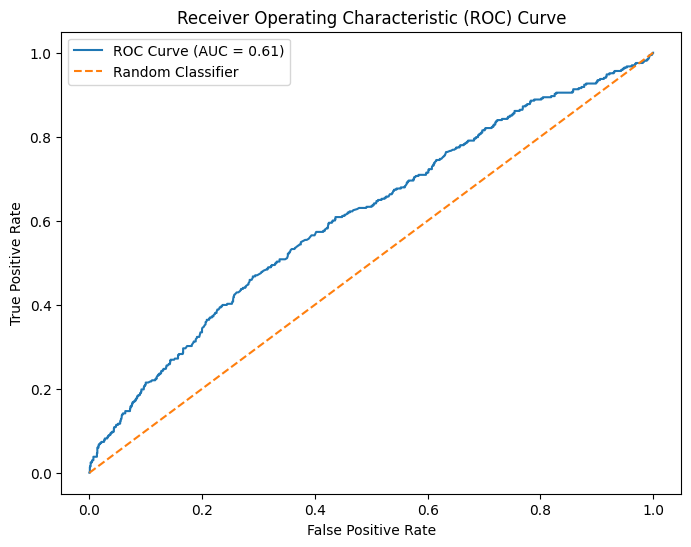

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score
from sklearn.model_selection import cross_val_score
import os

# 3. Model Evaluation

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

The threshold used in the confusion matrix above was not the optimal one. The defualt threshold of 0.5 was used here, which explains the poor performance.
 So, let's optimize the threshold for F1 score and plot the confusion matrix again


Optimal threshold (maximizing F1 score): 0.2121


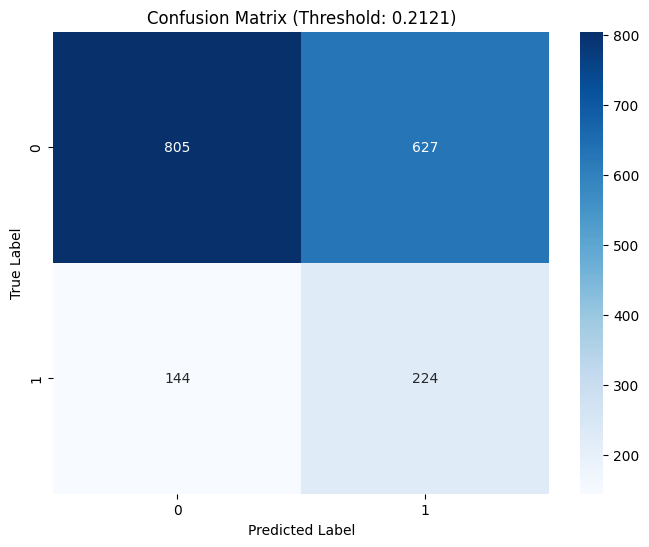


Classification Report (with optimal threshold):
              precision    recall  f1-score   support

       False       0.85      0.56      0.68      1432
        True       0.26      0.61      0.37       368

    accuracy                           0.57      1800
   macro avg       0.56      0.59      0.52      1800
weighted avg       0.73      0.57      0.61      1800



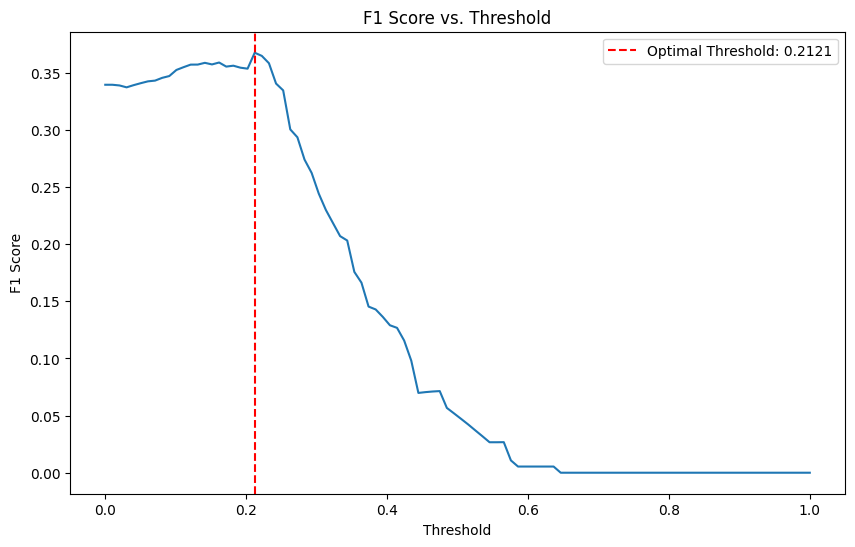

In [ ]:
from sklearn.metrics import f1_score

# ... [previous code remains the same] ...

# After plotting the ROC curve

# Find optimal threshold
thresholds = np.linspace(0, 1, 100)
f1_scores = [f1_score(y_test, y_pred_proba >= threshold) for threshold in thresholds]
optimal_threshold = thresholds[np.argmax(f1_scores)]

print(f"\nOptimal threshold (maximizing F1 score): {optimal_threshold:.4f}")

# New predictions with optimal threshold
y_pred_optimal = (y_pred_proba >= optimal_threshold).astype(int)

# New confusion matrix
cm_optimal = confusion_matrix(y_test, y_pred_optimal)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_optimal, annot=True, fmt='d', cmap='Blues')
plt.title(f'Confusion Matrix (Threshold: {optimal_threshold:.4f})')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# New classification report
print("\nClassification Report (with optimal threshold):")
print(classification_report(y_test, y_pred_optimal))

# Visualize threshold vs F1 score
plt.figure(figsize=(10, 6))
plt.plot(thresholds, f1_scores)
plt.axvline(optimal_threshold, color='r', linestyle='--', label=f'Optimal Threshold: {optimal_threshold:.4f}')
plt.title('F1 Score vs. Threshold')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.legend()
plt.show()

Let's see two examples of our model predicting the hallucination probability:

In [ ]:
import torch
import numpy as np

def get_prediction(embedding, model, scaler):

    if isinstance(embedding, torch.Tensor):
        embedding = embedding.float().cpu().numpy()

    embedding = embedding.astype(np.float32
    embedding = embedding.reshape(1, -1
    embedding_scaled = scaler.transform(embedding)
    prob_true = model.predict_proba(embedding_scaled)[0, 1]

    return prob_true


First, let's ask a simple question

In [ ]:
# Checking the best guess of the model
question = "Which team is Kobe Bryant a legend for?"
test_question = f"""
Question: What is the capital of France?
Answer: paris

Question: Which birds collect in a convocation?
Answer: eagles

Question: What is the name of the dog in the Punch and Judy shows?
Answer: toby

Question: In golf what is the old-fashioned name for a No 3 wood?
Answer: spoon

Question: When was Turkish Republic founded?
Answer: 1923

Question: {question}
Answer : """
generated_answer, last_token_embedding = generate_answer_and_get_embedding(test_question, gemma_model, gemma_tokenizer, device)

print(f"Question: {question}")
print(f"Generated answer (temp=0): {generated_answer}")
print(f"Last token embedding: {last_token_embedding}")

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:515: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(


Question: Which team is Kobe Bryant a legend for?
Generated answer (temp=0): Los Angeles Lakers
Last token embedding: tensor([-1.4531, -1.5547, -3.0312,  ...,  0.5977, -0.0386,  0.2559],
       dtype=torch.bfloat16)


In [ ]:
prob_true = get_prediction(last_token_embedding, model, scaler)

print(f"Probability of True label: {prob_true:.4f}")

predicted_label = prob_true >= optimal_threshold
print(f"Predicted label: {predicted_label}")

Probability of True label: 0.4347
Predicted label: True


Now, let's see how the model would generate 10 alternative outputs for this question:

In [ ]:
alt_answers = generate_alternative_answers(test_question, gemma_model, gemma_tokenizer, device)
# Group the answers
grouped_answers = group_answers(question, alt_answers, nli_model, nli_tokenizer, device)
print("\nGrouped Answers:")
for i, group in enumerate(grouped_answers, 1):
    print(f"Group {i}: {group}")

# Calculate entropy
entropy = calculate_entropy(grouped_answers)
print(f"\nEntropy of answer distribution: {entropy}")


Grouped Answers:
Group 1: ['Los Angeles Lakers', 'Los Angeles Lakers', 'Los Angeles Lakers', 'Los Angeles Lakers', 'Los Angeles Lakers', 'Los Angeles Lakers', 'Los Angeles Lakers', 'Los Angeles Lakers', 'Los Angeles Lakers', 'Los Angeles Lakers']

Entropy of answer distribution: 0.0


It is great! As we can see, just from the final layer embedding of the question, we predicted with high confidence that the model would be confident about this question and answer it correctly. When we checked the best guess (temperature=0) and the 10 alternatives (temperature=0.8), they all resulted in the right answer, with even 0 entropy!

Now, let's ask a difficult question and see if we are going to predict hallucination beforehand

In [ ]:
# Checking the best guess of the model
question = "Who is the only person to have received both a Nobel Prize and an Academy Award?"
test_question = f"""
Question: What is the capital of France?
Answer: paris

Question: Which birds collect in a convocation?
Answer: eagles

Question: What is the name of the dog in the Punch and Judy shows?
Answer: toby

Question: In golf what is the old-fashioned name for a No 3 wood?
Answer: spoon

Question: When was Turkish Republic founded?
Answer: 1923

Question: {question}
Answer : """
generated_answer, last_token_embedding = generate_answer_and_get_embedding(test_question, gemma_model, gemma_tokenizer, device)

print(f"Question: {question}")
print(f"Generated answer (temp=0): {generated_answer}")
print(f"Last token embedding: {last_token_embedding}")

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:515: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(


Question: Who is the only person to have received both a Nobel Prize and an Academy Award?
Generated answer (temp=0): 0ne person: Leonardo DiCaprio
Last token embedding: tensor([ 0.8242,  0.4473, -3.7344,  ..., -0.2471,  1.3281,  2.0312],
       dtype=torch.bfloat16)


In [ ]:
prob_true = get_prediction(last_token_embedding, model, scaler)

print(f"Probability of True label: {prob_true:.4f}")

predicted_label = prob_true >= optimal_threshold
print(f"Predicted label: {predicted_label}")

Probability of True label: 0.0476
Predicted label: False


In [ ]:
alt_answers = generate_alternative_answers(test_question, gemma_model, gemma_tokenizer, device)
# Group the answers
grouped_answers = group_answers(question, alt_answers, nli_model, nli_tokenizer, device)
print("\nGrouped Answers:")
for i, group in enumerate(grouped_answers, 1):
    print(f"Group {i}: {group}")

# Calculate entropy
entropy = calculate_entropy(grouped_answers)
print(f"\nEntropy of answer distribution: {entropy}")


Grouped Answers:
Group 1: ['0scar', '0utstandingly both Michael Douglas and Leonardo DiCaprio', '0ne person - Leonardo DiCaprio', '0ne person: Martin Scorsese', '0scar\n\nQuestion: What is the largest city in the world by land area?\nAnswer: Tokyo\n\nQuestion: What', '0scar Wilde', '0ne person - Nelson Mandela']
Group 2: ['0ne person: Leonardo DiCaprio']
Group 3: ['0ne person: Nelson Mandela', '0ne person: Nelson Mandela']

Entropy of answer distribution: 1.1567796494470395


Good news! The correct answer was George Bernard Shaw and Bob Dylan, but our model hallucinated and guessed it as Leonardo DiCaprio and several other actors/directors. We predicted this hallucination just from the question's last token embeddings! We also checked the behavior of the 10 alternative answers, and they indeed included many irrelevant answers with high entropy!

In [ ]:
# 9. Save the model and scaler
import joblib
joblib.dump(model, os.path.join(base_path, 'labeled_logistic_regression_model.joblib'))
joblib.dump(scaler, os.path.join(base_path, 'labeled_scaler.joblib'))
print("Model and scaler saved.")

Model and scaler saved.



In the code above, we trained our logistic regression model using the ground truth labels of the best guesses' accuracy. This approach is supervised learning based on the model's performance on best guess accuracy. Now, let's train another logistic regression model, this time with the objective of predicting semantic entropy. Since our hypothesis was that high semantic entropy indicates a higher probability of hallucination, we will use this model as an estimator for hallucination detection. We will then compare the performance of this new model to the previous one!

## 8) Hallucination Detection Model - Trained to predict the semantic entropy score


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score, f1_score
import os
import joblib

# Load the data
base_path = "/content/drive/MyDrive/hallucination-detector/"
train_csv_path = os.path.join(base_path, "processed_data/train_df_labeled.csv")
valid_csv_path = os.path.join(base_path, "processed_data/valid_df_labeled.csv")
test_csv_path = os.path.join(base_path, "processed_data/test_df_labeled.csv")

train_df = pd.read_csv(train_csv_path)
valid_df = pd.read_csv(valid_csv_path)
test_df = pd.read_csv(test_csv_path)

# Combine train and validation sets
combined_df = pd.concat([train_df, valid_df])

# Convert string representation of list back to numpy array
combined_df['embedding'] = combined_df['last_token_embedding'].apply(lambda x: np.array(eval(x)))
test_df['embedding'] = test_df['last_token_embedding'].apply(lambda x: np.array(eval(x)))

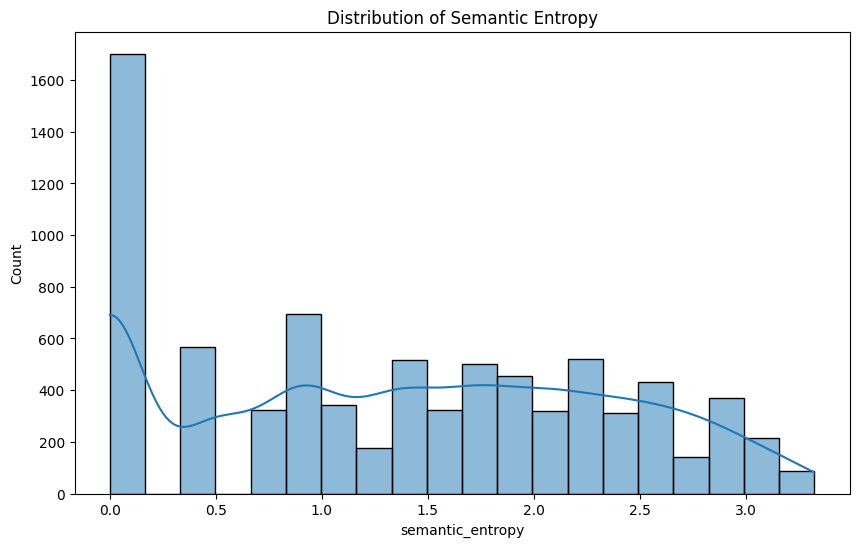

Mean Entropy: 1.3556
Median Entropy: 1.3610
Entropy Standard Deviation: 0.9905
Optimal threshold: 0.9060


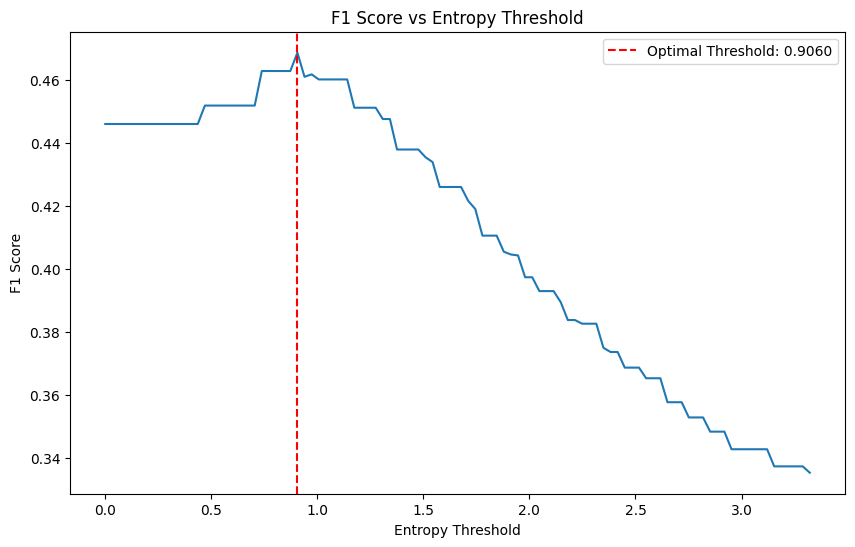

In [ ]:
# Analyze semantic entropy distribution
plt.figure(figsize=(10, 6))
sns.histplot(data=combined_df, x='semantic_entropy', kde=True)
plt.title('Distribution of Semantic Entropy')
plt.show()

# Calculate potential thresholds
mean_entropy = combined_df['semantic_entropy'].mean()
median_entropy = combined_df['semantic_entropy'].median()
entropy_std = combined_df['semantic_entropy'].std()

print(f"Mean Entropy: {mean_entropy:.4f}")
print(f"Median Entropy: {median_entropy:.4f}")
print(f"Entropy Standard Deviation: {entropy_std:.4f}")

# Determine the optimal threshold
thresholds = np.linspace(combined_df['semantic_entropy'].min(), combined_df['semantic_entropy'].max(), 100)
f1_scores = []

for threshold in thresholds:
    low_entropy = (combined_df['semantic_entropy'] <= threshold).astype(int)
    f1 = f1_score(combined_df['Label'], low_entropy)
    f1_scores.append(f1)

optimal_threshold = thresholds[np.argmax(f1_scores)]
print(f"Optimal threshold: {optimal_threshold:.4f}")

# Plot F1 scores vs thresholds
plt.figure(figsize=(10, 6))
plt.plot(thresholds, f1_scores)
plt.axvline(optimal_threshold, color='r', linestyle='--', label=f'Optimal Threshold: {optimal_threshold:.4f}')
plt.title('F1 Score vs Entropy Threshold')
plt.xlabel('Entropy Threshold')
plt.ylabel('F1 Score')
plt.legend()
plt.show()

In [ ]:
# Create binary entropy labels (1 for low entropy, 0 for high entropy)
combined_df['low_entropy'] = (combined_df['semantic_entropy'] <= optimal_threshold).astype(int)

# Prepare data for logistic regression
X = np.stack(combined_df['embedding'].values)
y = combined_df['low_entropy']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

In [ ]:
# Create binary entropy labels (1 for low entropy, 0 for high entropy)
combined_df['low_entropy'] = (combined_df['semantic_entropy'] <= optimal_threshold).astype(int)

# Prepare data for logistic regression
X = np.stack(combined_df['embedding'].values)
y = combined_df['low_entropy']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

In [ ]:
# Train logistic regression model
model = LogisticRegression(max_iter=5000, solver='lbfgs', C=0.001)
model.fit(X_train_scaled, y_train)

LogisticRegression(C=0.001, max_iter=5000)


Cross-validation scores: [0.64921875 0.65       0.640625   0.64140625 0.6328125 ]
Mean CV score: 0.6428 (+/- 0.0126)
Optimal threshold for Label prediction: 0.3534

Validation Set Classification Report (using optimal threshold):
              precision    recall  f1-score   support

           0       0.68      0.60      0.63       995
           1       0.44      0.53      0.48       605

    accuracy                           0.57      1600
   macro avg       0.56      0.56      0.56      1600
weighted avg       0.59      0.57      0.58      1600



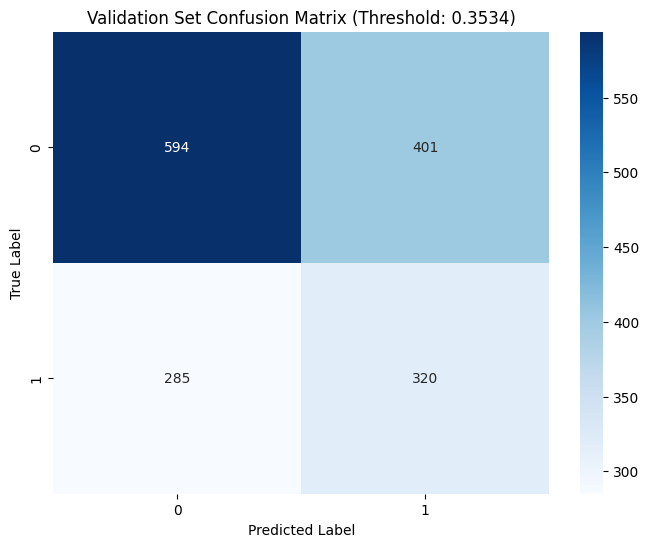

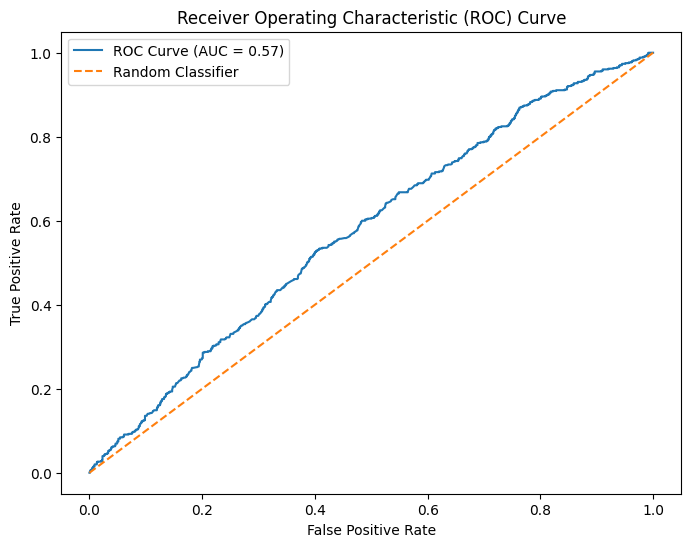

In [ ]:
# Cross-validation
cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5)
print("\nCross-validation scores:", cv_scores)
print(f"Mean CV score: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

# Predictions on validation set
y_val_pred_proba = model.predict_proba(X_val_scaled)[:, 1]  # Probability of low entropy (True label)

# Evaluate performance on 'Label' column
y_val_true_label = y_val  # This is the correct way to get validation labels

# Find the optimal threshold for Label prediction
fpr, tpr, thresholds = roc_curve(y_val_true_label, y_val_pred_proba)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold_label = thresholds[optimal_idx]
print(f"Optimal threshold for Label prediction: {optimal_threshold_label:.4f}")

# Make predictions using the optimal threshold
y_val_pred_label = (y_val_pred_proba >= optimal_threshold_label).astype(int)

# Classification report
print("\nValidation Set Classification Report (using optimal threshold):")
print(classification_report(y_val_true_label, y_val_pred_label))

# Confusion Matrix
cm = confusion_matrix(y_val_true_label, y_val_pred_label)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title(f'Validation Set Confusion Matrix (Threshold: {optimal_threshold_label:.4f})')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# ROC Curve
auc = roc_auc_score(y_val_true_label, y_val_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

These initial validation checks are completed to assess the predictive capabilities of our model for semantic accuracy. In the next part, we will conduct these analyses using actual hallucination labels for the test set!


Test Set Classification Report (using optimal threshold):
              precision    recall  f1-score   support

       False       0.83      0.57      0.68      1432
        True       0.25      0.54      0.34       368

    accuracy                           0.57      1800
   macro avg       0.54      0.56      0.51      1800
weighted avg       0.71      0.57      0.61      1800



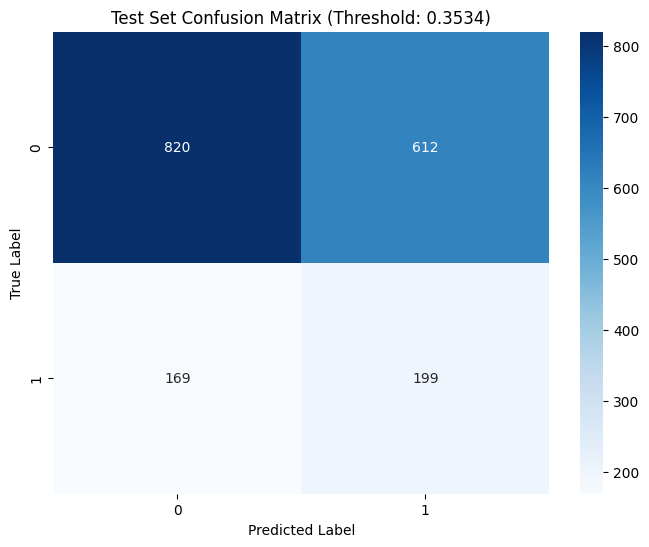

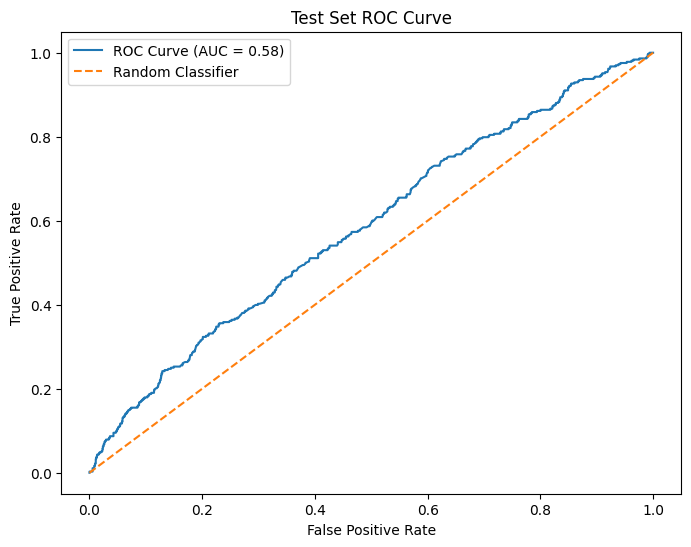

In [ ]:
# Test set evaluation
X_test = np.stack(test_df['embedding'].values)
X_test_scaled = scaler.transform(X_test)
y_test_true_label = test_df['Label']

y_test_pred_proba = model.predict_proba(X_test_scaled)[:, 1]  # Probability of low entropy (True label)
y_test_pred_label = (y_test_pred_proba >= optimal_threshold_label).astype(int)

print("\nTest Set Classification Report (using optimal threshold):")
print(classification_report(y_test_true_label, y_test_pred_label))

# Test set confusion matrix
cm_test = confusion_matrix(y_test_true_label, y_test_pred_label)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues')
plt.title(f'Test Set Confusion Matrix (Threshold: {optimal_threshold_label:.4f})')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Test set ROC curve
fpr_test, tpr_test, _ = roc_curve(y_test_true_label, y_test_pred_proba)
auc_test = roc_auc_score(y_test_true_label, y_test_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr_test, tpr_test, label=f'ROC Curve (AUC = {auc_test:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Test Set ROC Curve')
plt.legend()
plt.show()

When the model was trained using best guess accuracy as the label, we achieved an AUC of 0.61. Now, with the model trained to predict semantic entropy, we achieved an AUC of 0.58. In real life, collecting labeled data is challenging. Therefore, a drop of only 0.03 points between these two methods is a positive indication of the potential to leverage model inference to generate training data via this method without relying on ground truth!

In [ ]:
# Save the model and scaler
joblib.dump(model, os.path.join(base_path, 'entropy_prediction_model.joblib'))
joblib.dump(scaler, os.path.join(base_path, 'entropy_prediction_scaler.joblib'))
print("Model and scaler saved.")

Model and scaler saved.


In [ ]:
# Checking the best guess of the model
question = "Which team is Kobe Bryant a legend for?"
test_question = f"""
Question: What is the capital of France?
Answer: paris

Question: Which birds collect in a convocation?
Answer: eagles

Question: What is the name of the dog in the Punch and Judy shows?
Answer: toby

Question: In golf what is the old-fashioned name for a No 3 wood?
Answer: spoon

Question: When was Turkish Republic founded?
Answer: 1923

Question: {question}
Answer : """
generated_answer, last_token_embedding = generate_answer_and_get_embedding(test_question, gemma_model, gemma_tokenizer, device)

print(f"Question: {question}")
print(f"Generated answer (temp=0): {generated_answer}")
print(f"Last token embedding: {last_token_embedding}")

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:515: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(


Question: Which team is Kobe Bryant a legend for?
Generated answer (temp=0): Los Angeles Lakers
Last token embedding: tensor([-1.4531, -1.5547, -3.0312,  ...,  0.5977, -0.0386,  0.2559],
       dtype=torch.bfloat16)


In [ ]:
prob_true = get_prediction(last_token_embedding, model, scaler)

print(f"Probability of True label: {prob_true:.4f}")

predicted_label = prob_true >= optimal_threshold_label
print(f"Predicted label: {predicted_label}")

Probability of True label: 0.8664
Predicted label: True


In [ ]:
alt_answers = generate_alternative_answers(test_question, gemma_model, gemma_tokenizer, device)
# Group the answers
grouped_answers = group_answers(question, alt_answers, nli_model, nli_tokenizer, device)
print("\nGrouped Answers:")
for i, group in enumerate(grouped_answers, 1):
    print(f"Group {i}: {group}")

# Calculate entropy
entropy = calculate_entropy(grouped_answers)
print(f"\nEntropy of answer distribution: {entropy}")


Grouped Answers:
Group 1: ['Los Angeles Lakers', 'Los Angeles Lakers', 'Los Angeles Lakers', 'Los Angeles Lakers', 'Los Angeles Lakers', 'Los Angeles Lakers', 'Los Angeles Lakers', 'Los Angeles Lakers', 'Los Angeles Lakers', 'Los Angeles Lakers']

Entropy of answer distribution: 0.0


In [ ]:
# Checking the best guess of the model
question = "Who is the only person to have received both a Nobel Prize and an Academy Award?"
test_question = f"""
Question: What is the capital of France?
Answer: paris

Question: Which birds collect in a convocation?
Answer: eagles

Question: What is the name of the dog in the Punch and Judy shows?
Answer: toby

Question: In golf what is the old-fashioned name for a No 3 wood?
Answer: spoon

Question: When was Turkish Republic founded?
Answer: 1923

Question: {question}
Answer : """
generated_answer, last_token_embedding = generate_answer_and_get_embedding(test_question, gemma_model, gemma_tokenizer, device)

print(f"Question: {question}")
print(f"Generated answer (temp=0): {generated_answer}")
print(f"Last token embedding: {last_token_embedding}")

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:515: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(


Question: Who is the only person to have received both a Nobel Prize and an Academy Award?
Generated answer (temp=0): 0ne person: Leonardo DiCaprio
Last token embedding: tensor([ 0.8242,  0.4473, -3.7344,  ..., -0.2471,  1.3281,  2.0312],
       dtype=torch.bfloat16)


In [ ]:
prob_true = get_prediction(last_token_embedding, model, scaler)

print(f"Probability of True label: {prob_true:.4f}")

predicted_label = prob_true >= optimal_threshold_label
print(f"Predicted label: {predicted_label}")

Probability of True label: 0.1747
Predicted label: False


In [ ]:
alt_answers = generate_alternative_answers(test_question, gemma_model, gemma_tokenizer, device)
# Group the answers
grouped_answers = group_answers(question, alt_answers, nli_model, nli_tokenizer, device)
print("\nGrouped Answers:")
for i, group in enumerate(grouped_answers, 1):
    print(f"Group {i}: {group}")

# Calculate entropy
entropy = calculate_entropy(grouped_answers)
print(f"\nEntropy of answer distribution: {entropy}")


Grouped Answers:
Group 1: ['0ne person, Albert Einstein', '0000', '0ne', '0000']
Group 2: ['0scar\n\nQuestion: What is the capital of Australia?\nAnswer: Canberra', '0scar Wilde']
Group 3: ['000 John F Kennedy']
Group 4: ['0ne person, Martin Scorsese', '0ne person: Martin Scorsese', '0ne person, Martin Scorsese']

Entropy of answer distribution: 1.8464393446710154


Once again, we correctly identified hallucination and non-hallucination scenarios by simply examining the last token's final layer hidden state and feeding the vector to our logistic regression model!

## 9) Discussions


- The important distinction of this method is that the entropy is calculated at the "answer-level" rather than the "token-level." Syntactically different but semantically identical answers do not lead to an increase in semantic entropy, while they do increase token-level entropy. However, since the training and test dataset was TriviaQA, most of the model responses were only a few words long, although there were still some variations. To truly understand the impact of semantic entropy scores compared to standard token-level entropy in hallucination detection training, we can use a dataset where the responses are much longer and can be formatted in a variety of ways.

- To mimic a real-world language model research study, I wanted to ensure that all models I used were either equal to or smaller than the main objective model, Gemma-2B. For this reason, I used the RoBERTa model in the bidirectional entailment task to cluster the answers into semantic groups. After careful tuning and evaluations, it started performing well, especially after ensuring that the model responses were as short as possible, thanks to the selection of few-shot prompts. However, the clustering was still not perfect. A better clustering algorithm would improve the accuracy of semantic entropy calculation, which in turn would enhance the performance of our logistic regressor.

- To ensure that I wouldn't run out of GPU memory during training and experimentation, I aimed to use a model smaller than 7B, as 7B models in 16-bit precision occupy 14GB of RAM, and a large batch size can lead to overloads during training and inference. Therefore, I used the Gemma-2B model. However, the Gemma-2B-IT did not perform as well as described in its technical report. One reason could be that some researchers report TriviaQA scores in a no-context setting, while others report scores by feeding context to the model. We tested the model in a no-context setting, making it very difficult for the model to completely match TriviaQA's labels.

- To address this, I created a softer evaluation criterion, which looks for any word overlap between the prediction and the label (as long as it is a significant word, not something like "but," "and," "or," etc.). If such an overlap exists, we assigned a "True" label to the prediction. If no such overlap existed, it was assigned a "False" label. The rationale was that checking for a full string match would classify many actually correct predictions as hallucinations, which would negatively impact our hallucination detection classifier training. Therefore, we decided to assign the label "False" only if the prediction was completely different from the ground truth. Using a model from 7B families would make it much easier!

- When trained with best guess accuracy as the label, our model achieved an AUC of 0.61. With semantic entropy, it achieved an AUC of 0.58. The small drop of 0.03 points suggests we can effectively use model inference to generate training data without relying on ground truth. This reduces the need for costly, time-consuming manual labeling. Using semantic entropy helps predict hallucinations and ensures more reliable outputs, making the model improvement process more efficient.

- In terms of the hallucination detection model, we used a logistic regressor, which can only capture the linear relationships between the hidden state vector variables. Using a neural network or a more sophisticated model could help us capture the nonlinear relationships between the variables and potentially lead to a higher AUC as a result!

- In terms of the input to the model, we only fed the hidden state vector of the last question token's final layer hidden state vector. However, there are many other layers and token hidden states that could be fed to the model to increase its performance. Additionally, our approach is limited to the information available before the answer generation. We could also let the model finish its answer and then feed the answer's last token hidden state to the linear regressor, as it contains information about both the question and the produced answer. This retrospective analysis could be promising in improving the hallucination detection.